# Final Individual Recommender System

# Importing the Datasets

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Make Pandas Display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the ratings data
ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')

# Load the wines data
wines_df_slim = pd.read_csv('../dataset/XWines_Slim_1K_wines.csv')
wines_df_full = pd.read_csv('../dataset/XWines_Full_100K_wines.csv')


/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_52646/1459283311.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_52646/1459283311.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')


# Data Pre-Processing

In [4]:
# Dropping some of the Columns in the wines_df
# Some are irrelevant for analysis (like the website) and some will just be repeated info (like the Code and Country)
wine_columns_to_drop_repeated = ['Website', 'Code', 'RegionID', 'WineryID', 'WineName', 'RegionName', 'WineryName']
wines_df_slim.drop(columns=wine_columns_to_drop_repeated, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_repeated, inplace=True)

In [5]:
# Dropping the Features we will not use for ML due to the extremely high dimensionality
wine_columns_to_drop_high_dimensionality = ['Grapes']
wines_df_slim.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)

In [6]:
# Convert string to list
import ast

wines_df_slim['Harmonize'] = wines_df_slim['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

wines_df_full['Harmonize'] = wines_df_full['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

In [7]:
# Processing Vintages
def process_vintages(vintages):
    # Remove "N.V." from the list
    filtered_vintages = [vintage for vintage in vintages if vintage != "N.V."]

    # Calculate the number of vintages
    num_vintages = len(filtered_vintages)

    # Find the oldest and most recent vintages
    oldest_vintage = min(filtered_vintages) if filtered_vintages else 0
    most_recent_vintage = max(filtered_vintages) if filtered_vintages else 0
    vintage_range = most_recent_vintage - oldest_vintage

    return num_vintages, oldest_vintage, most_recent_vintage, vintage_range

# Apply the function to each row
wines_df_slim[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_slim['Vintages'].apply(process_vintages).tolist()
wines_df_full[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_full['Vintages'].apply(process_vintages).tolist()

In [8]:
# Drop the original Vintages column for both datasets
wines_df_slim.drop(columns=['Vintages'], inplace=True)
wines_df_full.drop(columns=['Vintages'], inplace=True)

In [9]:
#some renaming if we want to use the lenskit later:
ratings_df_slim = ratings_df_slim.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
ratings_df_full = ratings_df_full.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})


wines_df_slim = wines_df_slim.rename(columns={'WineID': 'item'})
wines_df_full = wines_df_full.rename(columns={'WineID': 'item'})

In [10]:
# Explode 'Harmonize' column into individual rows
wines_exploded = wines_df_slim.explode('Harmonize')

# One-hot encode the 'Harmonize' column with the desired prefix
harmonize_one_hot = pd.get_dummies(wines_exploded['Harmonize'], prefix='harmonize_with')

# Group by 'item' and sum to combine back into single rows per item
harmonize_one_hot_grouped = harmonize_one_hot.groupby(wines_exploded['item']).sum()

# Merge the one-hot encodings with the original DataFrame
wines_df_slim = wines_df_slim.merge(harmonize_one_hot_grouped, left_on='item', right_index=True, how='left')
wines_df_full = wines_df_full.merge(harmonize_one_hot_grouped, left_on='item', right_index=True, how='left')

In [11]:
# Drop the Harmonize Column on both versions for the wines
wines_df_slim.drop(columns=['Harmonize'], inplace=True)
wines_df_full.drop(columns=['Harmonize'], inplace=True)


In [12]:
# Performing One Hot Encodding for the Categorical Features
wines_df_slim = pd.get_dummies(wines_df_slim, columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'])
wines_df_full = pd.get_dummies(wines_df_full, columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'])


In [13]:
# Scale the Numerical Features
numerical_features_to_scale = ['ABV', 'num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']

# Scale the numerical features for both datasets
from sklearn.preprocessing import StandardScaler

scaler_for_slim = StandardScaler()
wines_df_slim[numerical_features_to_scale] = scaler_for_slim.fit_transform(wines_df_slim[numerical_features_to_scale])

scaler_for_full = StandardScaler()
wines_df_full[numerical_features_to_scale] = scaler_for_full.fit_transform(wines_df_full[numerical_features_to_scale])

In [14]:
# How the Wines Dataset looks for ML
wines_df_slim.head()

,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,100001,-1.774251,0.385890,-0.026340,0.060097,0.553777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100002,-0.408248,-1.079531,0.251772,0.028623,-1.418160,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,100003,-0.408248,-0.442391,-0.074016,0.067966,0.907715,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,100005,-0.711804,-0.378677,0.005445,0.067966,0.402090,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fal

## Create the Mask for the Ratings
* 1 - 3.5 - 0
* 4 - 4.5 - 1
* 4.5 - 5 - 2

In [15]:
# Go through the Ratings on both datasets and subsitute the values based on conditions. 
# <=3.5 becomes 0
# 4 becomes 1
# >= 4.5 becomes 2
def label_rating(rating):
    if rating <= 3.5: #~41%
        return 0
    elif rating == 4.0: #~36%
        return 1
    elif 4.5 <= rating <= 5.0: #~22%
        return 2

# Apply the function to create the new column 'rating_label'
ratings_df_slim['rating_label'] = ratings_df_slim['rating'].apply(label_rating)
ratings_df_full['rating_label'] = ratings_df_full['rating'].apply(label_rating)


# Content Based 

In [16]:
# Perform an 80/20 stratified split for each user
train_list = []
test_list = []

merged_data = pd.merge(ratings_data, items_data, on='item', how='left')

# Group by 'user' and split within each group
for user, group in ratings_df_slim.groupby('user'):
    train, test = train_test_split(group, test_size=0.2, random_state=42, stratify=group['item'])
    train_list.append(train)
    test_list.append(test)

NameError: name 'ratings_data' is not defined

0.23
1.29
2.6
12.83
24.35
36.02
14.74
7.64


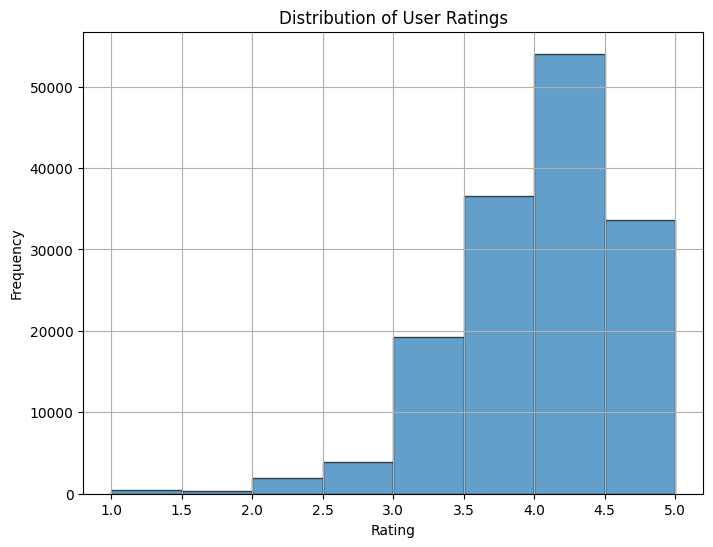

In [ ]:
bins = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
rating_counts = pd.cut(ratings_df_slim['rating'], bins=bins).value_counts(sort=False)

# Print the counts for each class
for rating in rating_counts:
    print(round((rating / 150000) * 100, 2))

# Plot the histogram as before
plt.figure(figsize=(8, 6))
ratings_df_slim['rating'].hist(bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.grid(True)
plt.show()

In [ ]:
rating_counts = ratings_df_slim['rating'].value_counts().sort_index(ascending=False)
print(rating_counts)

rating
5.0    11455
4.5    22103
4.0    54035
3.5    36518
3.0    19238
2.5     3895
2.0     1930
1.5      351
1.0      475
Name: count, dtype: int64
